In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 15})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
xf, yf = 0.1, 10.
def f(x, y):
    return -np.exp(-(x ** 2 * xf + y ** 2 * yf))

In [38]:
x = np.arange(-2,2, 0.1)
y = np.arange(-2,2, 0.1)
X, Y = np.meshgrid(x, y)

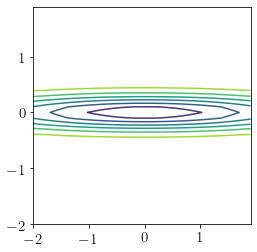

In [39]:
V = f(X, Y)
# plt.imshow(V)
plt.contour(X, Y, V)
# plt.axis("equal")
plt.gca().set_aspect('equal')
# plt.xlim((-2, 2))
# plt.ylim((-2, 2))

In [8]:
def grad_f(x, y):
    expart = -(x ** 2 * xf + y ** 2 * yf)
    return (xf * x * np.exp(expart), yf * y * np.exp(expart))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-1.9500000000000002, 40.95, -1.9500000000000002, 40.95)

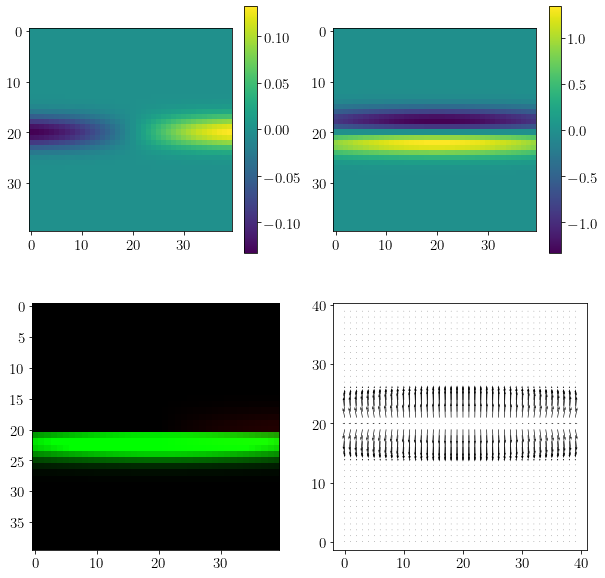

In [42]:
VV = grad_f(X, Y)
plt.subplots(2,2, figsize=(10,10))
plt.subplot(221)
plt.imshow(VV[0])
plt.colorbar()
plt.subplot(222)
plt.imshow(VV[1])
plt.colorbar()
plt.subplot(223)
plt.imshow(np.stack([VV[0], VV[1], np.zeros(VV[0].shape)], axis=2))
plt.subplot(224)
plt.quiver(VV[0], VV[1])
plt.axis("equal")

In [10]:
def descent(g, state=(0,0), rate=0.1, max_iter=100):
    state = np.array(state)
    history = [state]
    for i in range(max_iter):
        grad_f = np.array(g(*state))
        state = state - rate * grad_f
        history.append(state)
    return history

In [11]:
history = descent(grad_f, (0.8,0.2), rate=0.5, max_iter=50)

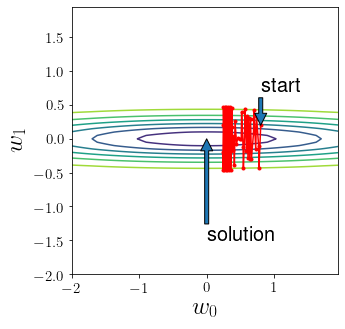

In [12]:
history = np.array(history)
plt.subplots(figsize=(5,5))
plt.contour(X, Y, V)
plt.plot(history[:,0], history[:,1], '.-r')
plt.annotate("start", xy=history[0], xytext=history[0] + (0., 0.5), fontsize=20, arrowprops={})
plt.annotate("solution", xy=(0,0), xytext=(0., -1.5), fontsize=20, arrowprops={})
plt.xlabel("$w_0$", fontsize=25)
plt.ylabel("$w_1$", fontsize=25)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("../statistics/images/valley_of_death.pdf")

\begin{align}
\frac{\partial f}{\partial x} &= -2 \alpha x \exp\left(-(\alpha x^2 + \beta y^2) \right) \\
\frac{\partial f}{\partial y} &= -2 \beta x \exp\left(-(\alpha x^2 + \beta y^2) \right) \\
\frac{\partial^2 f}{\partial x^2} &= (4 \alpha^2 - 2 \alpha) \exp\left(-(\alpha x^2 + \beta y^2) \right) \\
\frac{\partial^2 f}{\partial y^2} &= (4 \beta^2 - 2 \beta) \exp\left(-(\alpha x^2 + \beta y^2) \right) \\
\frac{\partial^2 f}{\partial x \partial y} &= 4 \alpha\beta xy \exp\left(-(\alpha x^2 + \beta y^2) \right)
\end{align}

Then the Hessian is
\begin{align}
H_{ij} &= 
\begin{pmatrix}
\frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\
\frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2}
\end{pmatrix} \\
&=
\begin{pmatrix}
4 \alpha^2 - 2 \alpha & 4 \alpha\beta xy \\
4 \alpha\beta xy & 4 \beta^2 - 2 \beta
\end{pmatrix} \exp\left(-(\alpha x^2 + \beta y^2) \right)
\end{align}

In [13]:
def hess_f(x, y):
#     print(f"hess {x} {y}")
    a = 4 * xf ** 2 * x ** 2 - 2 * xf
    b = 4 * xf * yf * x * y
    d = 4 * yf ** 2 * y ** 2 - 2 * yf
    return np.matrix([[a, b], [b, d]]) * f(x, y)

def hessinv_f(x, y):
#     print(f"hess {x} {y}")
    a = 4 * xf ** 2 * x ** 2 - 2 * xf
    b = 4 * xf * yf * x * y
    d = 4 * yf ** 2 * y ** 2 - 2 * yf
    det = 1. / (a * d - b ** 2)
    return det * np.matrix([[d, -b], [-b, a]]) / f(x, y)

In [14]:
import sympy as sp
a, b, c, d = sp.symbols("a b c d")
m = sp.Matrix([[a, b], [b, d]])
m

Matrix([
[a, b],
[b, d]])

In [15]:
m ** -1

Matrix([
[ d/(a*d - b**2), -b/(a*d - b**2)],
[-b/(a*d - b**2),  a/(a*d - b**2)]])

In [16]:
def descent_newton(g, h, state=(0,0), rate=0.1, max_iter=100):
    state = np.matrix(state).reshape((-1,1))
    history = [state]
    for i in range(max_iter):
        hessinv = h(state[0,0], state[1,0])
        grad = g(state[0,0], state[1,0])
        delta = -rate * hessinv @ np.matrix(grad).reshape((-1,1))
        # print(f"[{i}] state: {state.squeeze()} grad: {grad} delta: {delta.squeeze()}\nhess: {hessinv}")
        state = state + delta
        history.append(state)
    return history

In [17]:
def plot_descent_newton(history, filename="valley_of_no_survive", title="OK"):
    history = np.array(history).squeeze()
    print(history.shape)
    plt.subplots(figsize=(5,5))
    plt.contour(X, Y, V)
    plt.plot(history[:,0], history[:,1], '.-r')
    # for i, point in enumerate(history):
    #     plt.annotate(f"{i}", xy=point, fontsize=9)
    plt.annotate("start", xy=history[0], xytext=history[0] + (0., 0.5), fontsize=20, arrowprops={})
    plt.annotate("solution", xy=(0,0), xytext=(0., -1.5), fontsize=20, arrowprops={})
    plt.xlabel("$w_0$", fontsize=25)
    plt.ylabel("$w_1$", fontsize=25)
    plt.gca().set_aspect('equal')
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.savefig(f"../statistics/images/{filename}.pdf")

(51, 2)


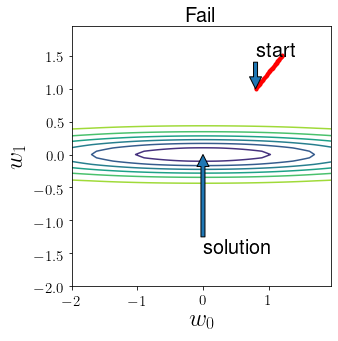

In [18]:
plot_descent_newton(descent_newton(grad_f, hessinv_f, (0.8,1.), rate=0.5, max_iter=50), "valley_of_newton_fail", "Fail")

(51, 2)


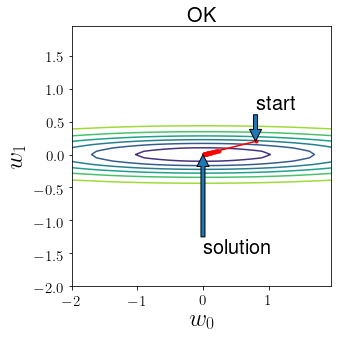

In [19]:
plot_descent_newton(descent_newton(grad_f, hessinv_f, (0.8,0.2), rate=0.1, max_iter=50), "valley_of_newton_ok", "OK")

In [20]:
def descent_lm(f, g, h, state=(0,0), rate=0.1, max_iter=100):
    state = np.matrix(state).reshape((-1,1))
    history = [state]
    lmda = 1.
    lmda_history = [lmda]
    cost_history = []
    for i in range(max_iter):
        cost = f(state[0,0], state[1,0])
        hess = h(state[0,0], state[1,0])
        grad = g(state[0,0], state[1,0])
        #delta = -rate * np.matrix(hess + lmda * np.diag(np.diag(hess))) ** -1 @ np.matrix(grad).reshape((-1,1))
        delta = -rate * np.matrix((hess + lmda * np.eye(hess.shape[0])) ** -1) @ np.matrix(grad).reshape((-1,1))
        # print(f"[{i}] state: {state} hess: {hess} delta: {delta}")
        new_state = state + delta
        new_cost = f(*new_state[:,0])
        if cost < new_cost:
            lmda *= 10
        else:
            lmda /= 10
            state = new_state
        history.append(state)
        lmda_history.append(lmda)
        cost_history.append(cost)
    return history, lmda_history, cost_history

(51, 2)


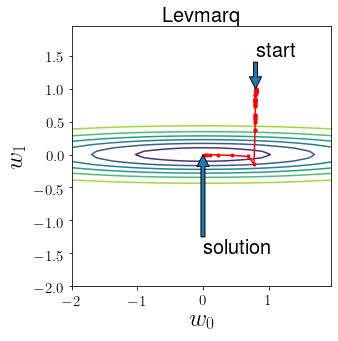

In [31]:
history, lmda_history, cost_history = descent_lm(f, grad_f, hess_f, (0.8,1.0), rate=1., max_iter=50)
plot_descent_newton(history, "valley_of_lm", "Levmarq")

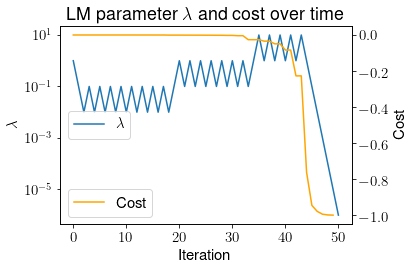

In [32]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.semilogy(lmda_history, label="$\lambda$")
ax.legend(loc="center left")
ax.set_xlabel("Iteration")
ax.set_ylabel("$\lambda$")
#print(cost_history)
ax2.plot(cost_history, 'orange', label="Cost")
ax2.set_ylabel("Cost")
ax2.legend()
ax.set_title("LM parameter $\lambda$ and cost over time")
plt.tight_layout()
plt.savefig(f"../statistics/images/lm_lambda_cost.pdf")

In [23]:
def descent_momentum(f, g, h, state=(0,0), rate=0.1, rate_momentum=0.1, max_iter=100):
    state = np.matrix(state).reshape((-1,1))
    history = [state]
    momentum = np.zeros(state.shape)
    momentum_history = [momentum]
    cost_history = []
    for i in range(max_iter):
        cost = f(state[0,0], state[1,0])
        #hess = h(state[0,0], state[1,0])
        grad = g(state[0,0], state[1,0])
        #delta = -rate * np.matrix(hess + lmda * np.diag(np.diag(hess))) ** -1 @ np.matrix(grad).reshape((-1,1))
        delta = -rate * np.matrix(grad).reshape((-1,1))
        momentum += rate_momentum * delta
        state = state + momentum + delta
        #print(f"[{i}] state: {state} momentum: {momentum} delta: {delta}")
        history.append(state)
        momentum_history.append(momentum)
        cost_history.append(cost)
    return history, momentum_history, cost_history

(26, 2)


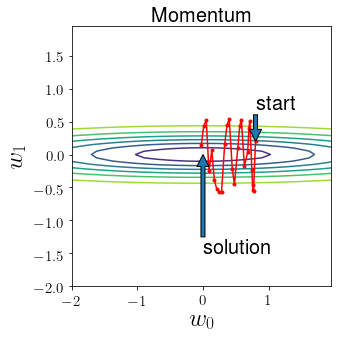

In [24]:
history, momentum_history, cost_history = descent_momentum(f, grad_f, hess_f, (0.8,0.2), rate=0.5, rate_momentum=0.2, max_iter=25)
plot_descent_newton(history, "valley_of_momentum", "Momentum")

In [104]:
def descent_line_search(g, h, state=(0,0), rate=0.1, max_iter=100):
    state = np.array(state).reshape((-1,1))
    history = [state]
    for i in range(max_iter):
        hessinv = h(state[0,0], state[1,0])
        grad = g(state[0,0], state[1,0])
        direction = np.array(-hessinv @ np.matrix(grad).reshape((-1,1)))
        direction /= (direction ** 2).sum()
        #print(direction, np.array(grad).reshape((-1,1)))
        scale = -rate * np.dot(direction.flat, np.array(grad).reshape(-1))
        delta = scale * direction
#         print(scale)
        # print(f"[{i}] state: {state.squeeze()} grad: {grad} delta: {delta.squeeze()}\nhess: {hessinv}")
        state = state + delta
        history.append(state)
    #print((history))
    return history

(151, 2)


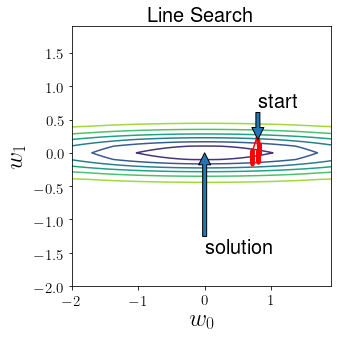

In [110]:
history = descent_line_search(grad_f, hess_f, (0.8,0.2), rate=0.5, max_iter=150)
plot_descent_newton(history, "valley_of_line_search", "Line Search")

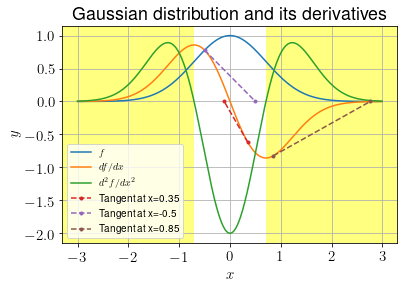

In [34]:

x = np.arange(-3,3,0.01)
y = np.exp(-x ** 2)
dfdx = lambda x: -2 * x * np.exp(-x ** 2)
dydx = dfdx(x)
df2dx = lambda x: (4 * x ** 2 - 2) * np.exp(-x ** 2)
dy2dx = df2dx(x)
for y,label in zip([y, dydx, dy2dx], ["$f$", "$df/dx$", "$d^2f/dx^2$"]):
    plt.plot(x, y, label=label)
plt.grid()

def plot_tangent(p):
    dypdx = dfdx(p)
    dyp2dx = df2dx(p)
    delta = -dypdx / dyp2dx
    plt.plot([p, p + delta], [dypdx, 0], '--.', label=f"Tangent at x={p}")

plot_tangent(0.35)
plot_tangent(-0.5)
plot_tangent(0.85)


plt.legend(loc="lower left", fontsize=10)

xl = plt.xlim()
yl = plt.ylim()
r = patches.Rectangle(xy=(xl[0], yl[0]), width=-0.7 - xl[0], height=yl[1] - yl[0], linewidth=None, fc=[1,1,0.5])
plt.gca().add_patch(r)
r = patches.Rectangle(xy=(0.7, yl[0]), width=xl[1] - 0.7, height=yl[1] - yl[0], linewidth=None, fc=[1,1,0.5])
plt.gca().add_patch(r)

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Gaussian distribution and its derivatives")
plt.savefig(f"../statistics/images/gaussian_derivatives.pdf")